In [1]:

import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
from data_plot import sample_distribution_galactic_coords, plot_radial_distribution, plot_distribution, display_polar_histogram, plot_variance_distribution, plot_velocity_distribution
import numpy as np
import emcee
from functools import reduce
import time, timeit
import transformation_constants
import datetime as dt
import photometric_cut
import os
import pickle
from pathlib import Path
import argparse
import random
import matplotlib.pyplot as plt


Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

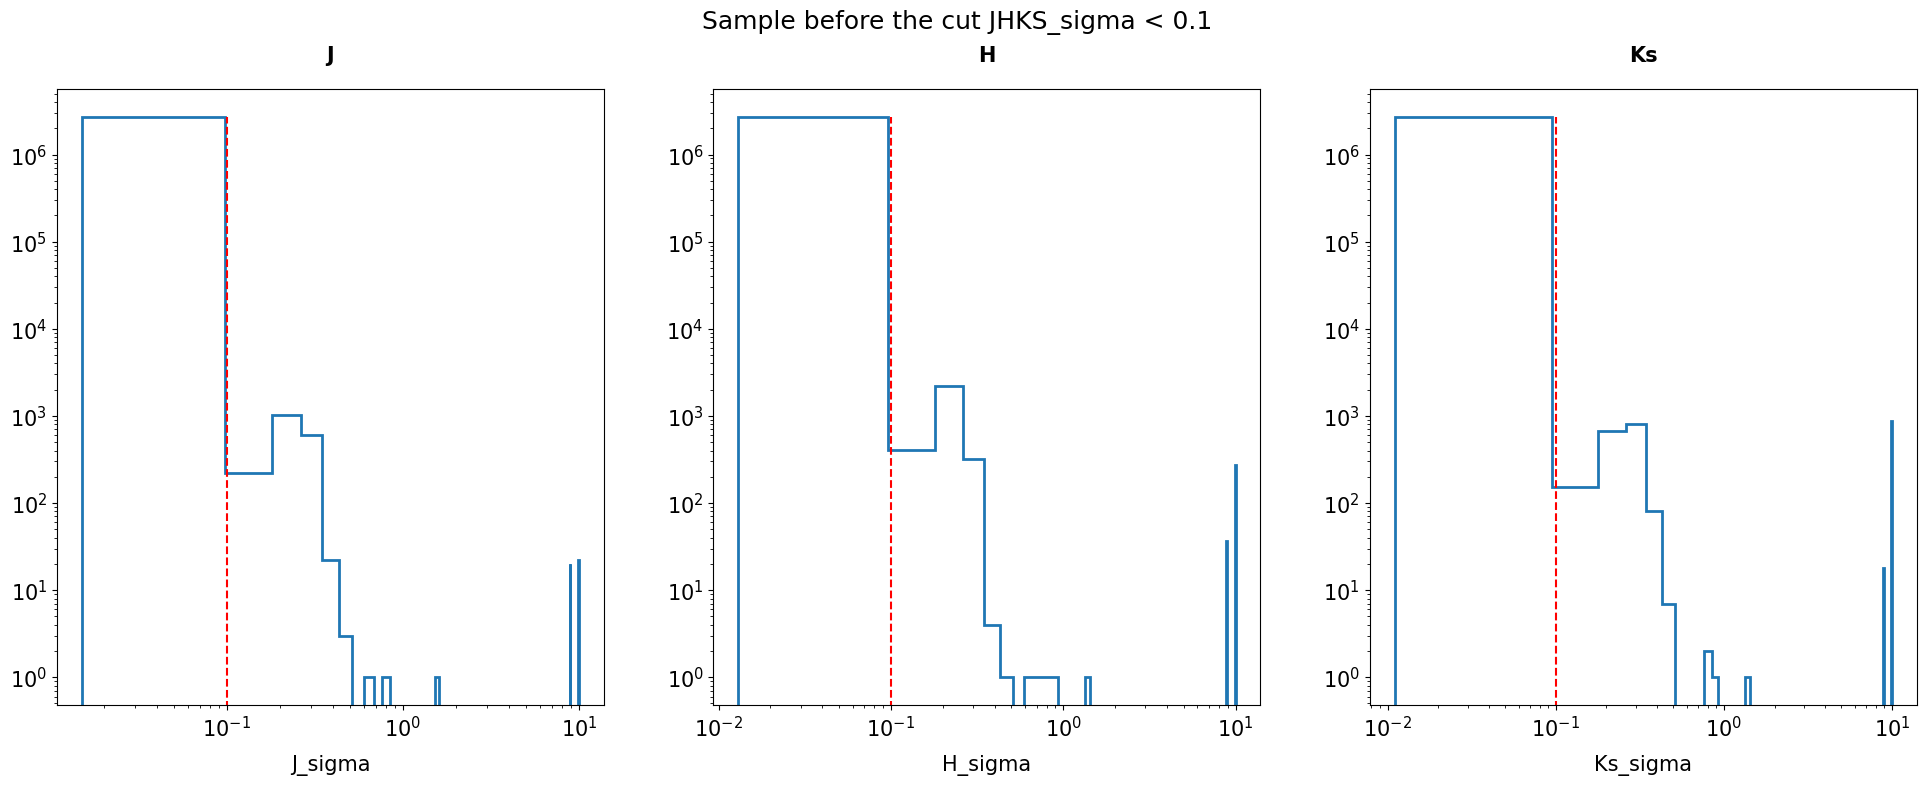

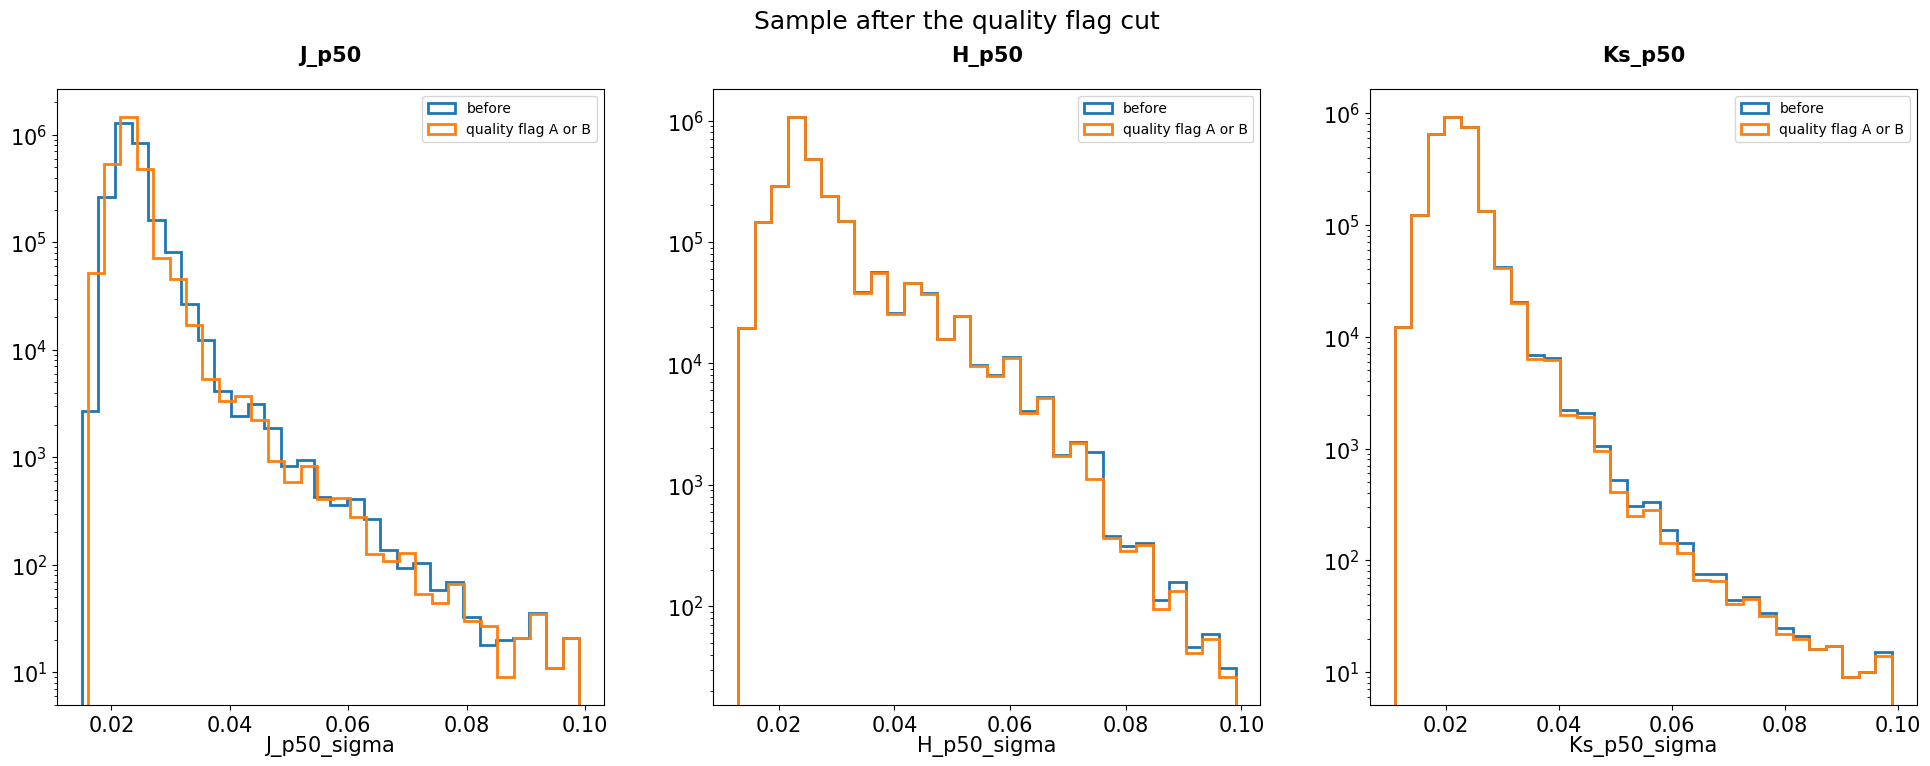

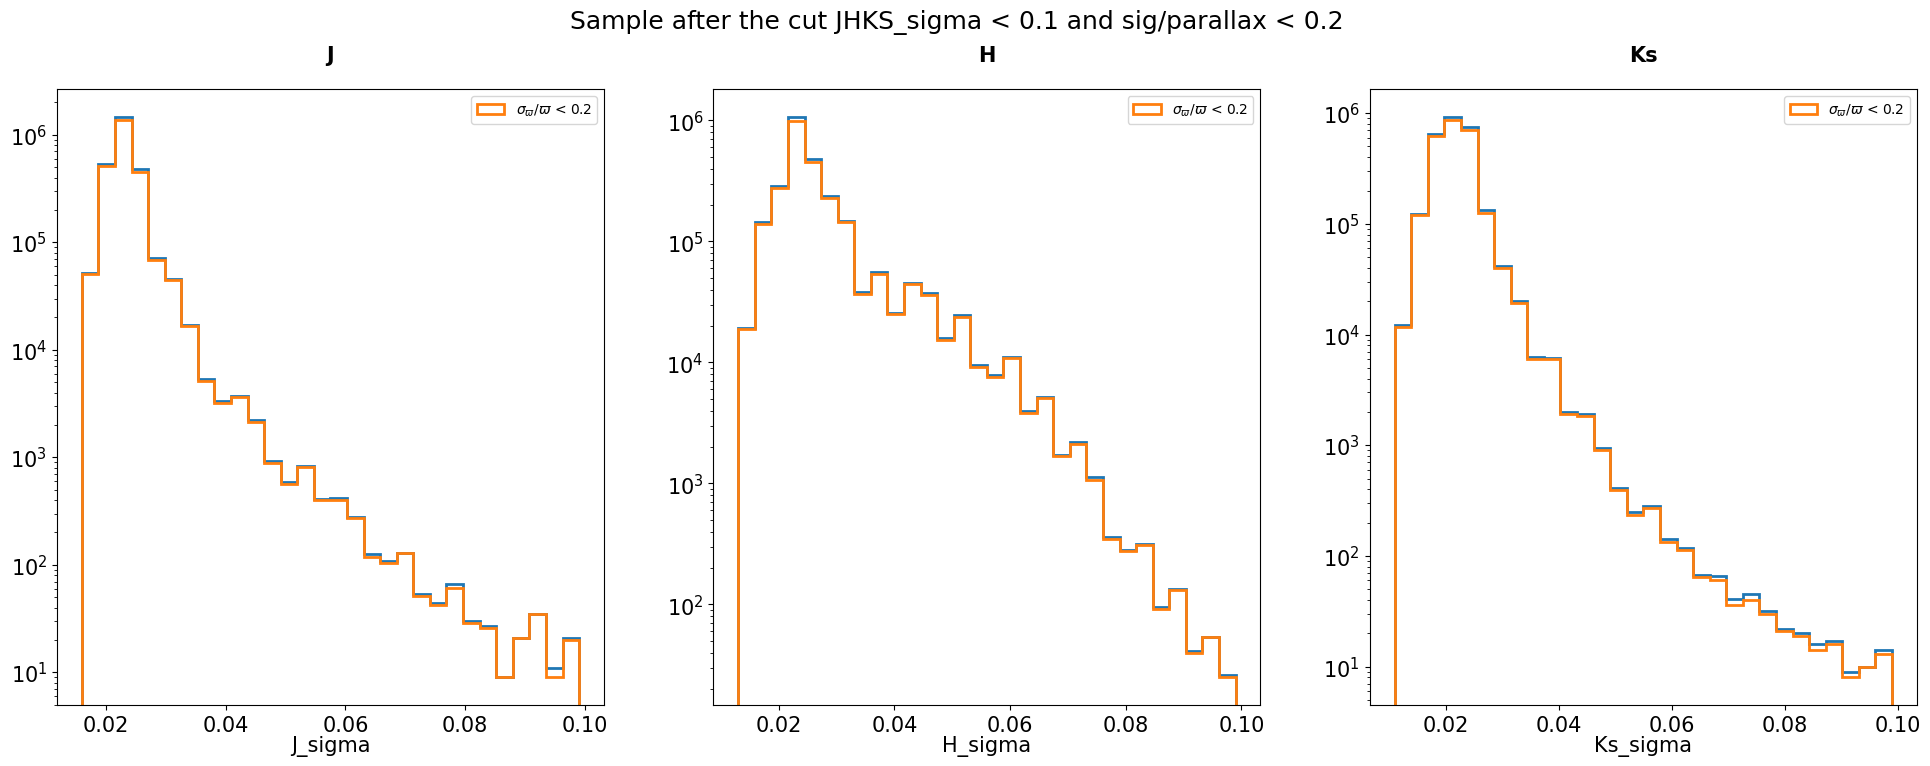

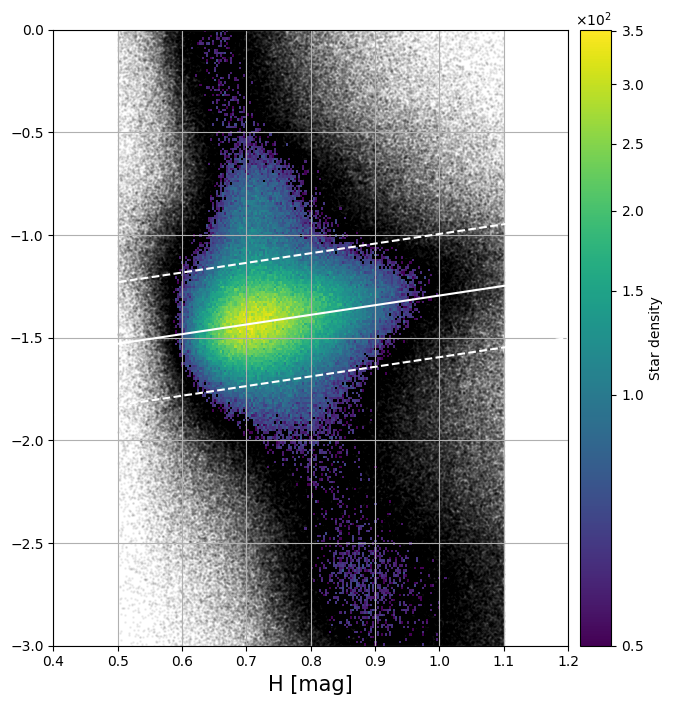

In [2]:

# Create outpath for current run
run_out_path = "/home/svenpoder/repos/gaia-tools/jupyter-notebook"

print("Photometric cut..")
sample_IDs = photometric_cut.get_sample_IDs(run_out_path, 0.3, True)

# The path containing the initial ICRS data with Bayesian distance estimates.
my_path = "/home/svenpoder/Gaia_2MASS Data_DR2/gaia_rv_data_bayes.csv"

# Import ICRS data
icrs_data = import_data(path = my_path, is_bayes = True, debug = True)
icrs_data = icrs_data.merge(sample_IDs, on='source_id', suffixes=("", "_y"))
icrs_data.reset_index(inplace=True, drop=True)

print("Size of sample after diagonal cut in ROI {}".format(icrs_data.shape))

## TRANSFORMATION CONSTANTS
v_sun = transformation_constants.V_SUN
z_0 = transformation_constants.Z_0
r_0 = transformation_constants.R_0

galcen_data = data_analysis.get_transformed_data(icrs_data,
                                       include_cylindrical = True,
                                       z_0 = z_0,
                                       r_0 = r_0,
                                       v_sun = v_sun,
                                       debug = True,
                                       is_bayes = True,
                                       is_source_included = True)

galactocentric_cov = cov.generate_galactocentric_covmat(icrs_data, True)
cyl_cov = cov.transform_cov_cylindirical(galcen_data, galactocentric_cov)
galcen_data = galcen_data.merge(cyl_cov, on='source_id')



# Final data selection
galcen_data = galcen_data[(galcen_data.r < 12000) & (galcen_data.r > 5000)]
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
galcen_data.reset_index(inplace=True, drop=True)
print("Final size of sample {}".format(galcen_data.shape))

icrs_data = icrs_data.merge(galcen_data, on='source_id')[icrs_data.columns]



min_r = np.min(galcen_data.r)
max_r = np.max(galcen_data.r)




In [ ]:
# Plots the velocity and velocity variance distribution of first 4 bins. 
plot_velocity_distribution(bin_collection.bins[0:4], run_out_path, True)
plot_variance_distribution(bin_collection.bins[0:4], 'v_phi', run_out_path)

In [82]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = min_r - 1,
                                                      BL_r_max = max_r + 1,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (10, 1),
                                                      r_drift = False,
                                                      debug = False)

0.6549592006721418
0.6731527081018972
0.5539860088231182
0.5303954344438604
0.4542509317060986
0.44962927361271166
0.4584379829724359
0.41513369266248445
0.45514760281704375
0.5946303642951764


([<matplotlib.axis.XTick at 0x7eebad005430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

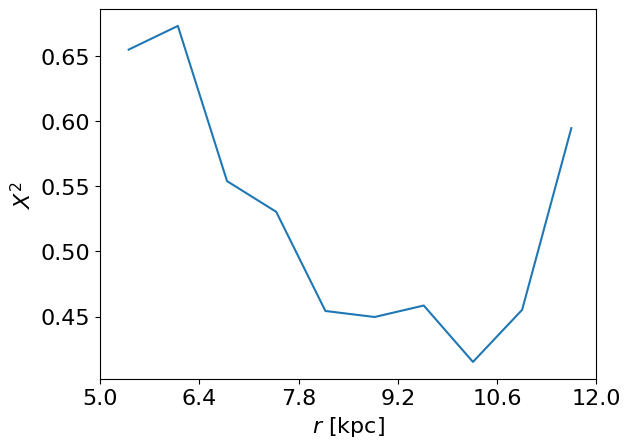

In [53]:
new_xx = []
for i, bin in enumerate(bin_collection.bins):
    nom = np.var(bin.data.v_phi)
    denom = np.mean(bin.data.v_r)**2 + np.var(bin.data.v_r)
    new_xx.append(nom/denom)
    print(nom/denom)

plt.plot(np.array(bin_mids)/1000, new_xx)
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$X^2$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))

In [86]:
velocity_var = []
bin_mids = []
xx_list = []
for i, bin in enumerate(bin_collection.bins):

    var_i = np.var(bin.data['v_r'])
    velocity_var.append(var_i)
    bin_mids.append(np.median(bin.r_boundaries))
    xx_list.append(np.var(bin.data.v_phi)/np.var(bin.data.v_r))


In [70]:
for i, bin in enumerate(bin_collection.bins):
    bin.med_sig_vphi = np.median(bin.data.sig_vphi)
    bin.A_parameter = bin.compute_A_parameter(debug=True)
    xx = np.var(bin.data.v_phi)/np.var(bin.data.v_r)

    rot_vel_var = np.var(bin.data.v_phi)
    rad_vel_var = np.var(bin.data.v_r)
    XX = rot_vel_var/rad_vel_var

    print("XX: {}".format(xx))
for bin in bin_collection.bins:
    bin.get_likelihood_w_asymmetry(-250, True)

1.8472538197587758
XX: 1.8472538197587758
0.39406812502335875
XX: 0.39406812502335875
0.8695026940130749
XX: 0.8695026940130749
0.7014968593482356
XX: 0.7014968593482356
0.6350791072134225
XX: 0.6350791072134225
0.7480066403220516
XX: 0.7480066403220516
0.7960271025411114
XX: 0.7960271025411114
0.694028203725352
XX: 0.694028203725352
0.6393616274365077
XX: 0.6393616274365077
0.6485786377380489
XX: 0.6485786377380489
0.6506321875903545
XX: 0.6506321875903545
0.5748649418188045
XX: 0.5748649418188045
0.5690034609310577
XX: 0.5690034609310577
0.5467087036133127
XX: 0.5467087036133127
0.5186315774508147
XX: 0.5186315774508147
0.5405451825677635
XX: 0.5405451825677635
0.5726789107898081
XX: 0.5726789107898081
0.536492289526363
XX: 0.536492289526363
0.5212149012937198
XX: 0.5212149012937198
0.4969065811726621
XX: 0.4969065811726621
0.48291085381310456
XX: 0.48291085381310456
0.45307492683084327
XX: 0.45307492683084327
0.44307532384311077
XX: 0.44307532384311077
0.4569778646141131
XX: 0.45697

([<matplotlib.axis.XTick at 0x7f4af68a39d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

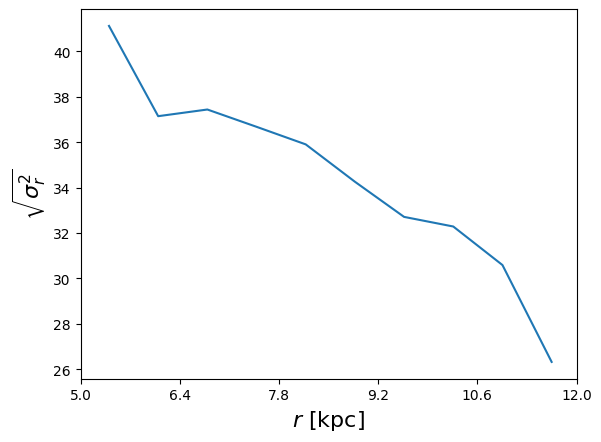

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.array(bin_mids)/1000, np.sqrt(velocity_var))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\sqrt{\sigma_r^2}$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))

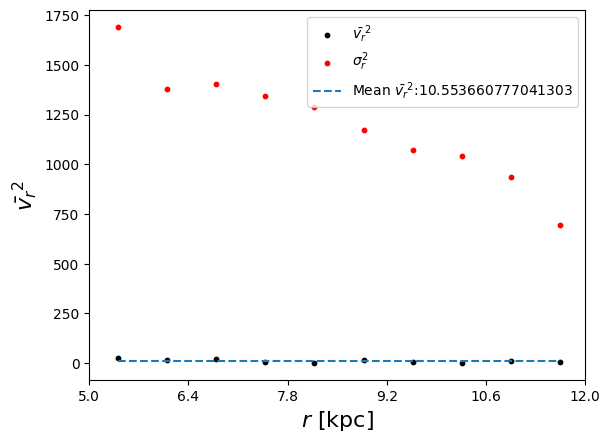

In [6]:
from cProfile import label
from turtle import color


mean_vel = []
bin_mids = []

for i, bin in enumerate(bin_collection.bins):
    bin_mids.append(np.median(bin.r_boundaries))
    mean_vel.append(np.mean(bin.data.v_r))
    #print(np.mean(bin.data.v_r))

mean_vel = np.array(mean_vel)

plt.scatter(np.array(bin_mids)/1000, mean_vel**2, s=10, color='black', label=r'$\bar{v_r}^2$')
plt.scatter(np.array(bin_mids)/1000, velocity_var, s=10, color='red', label=r'$\sigma^2_r$')

overall_mean = np.mean(mean_vel[~np.isnan(mean_vel)]**2)

plt.hlines(overall_mean, 
                    bin_mids[0]/1e3, bin_mids[-1]/1e3, 
                    linestyles='--', 
                    label="Mean " + r"$\bar{v_r}^2$:" + "{}".format(overall_mean))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\bar{v_r}^2$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))
plt.legend()



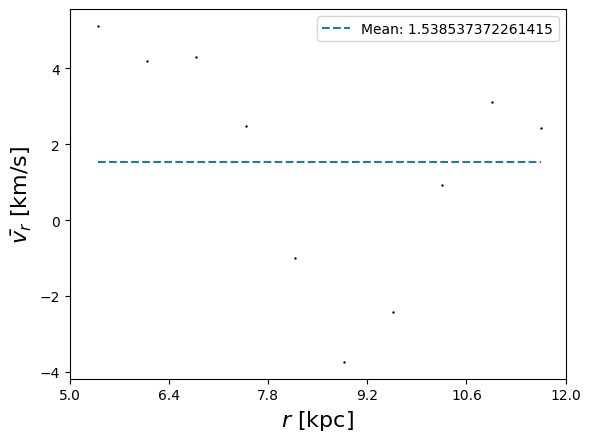

In [8]:
mean_vel = []
bin_mids = []

for i, bin in enumerate(bin_collection.bins):
    bin_mids.append(np.median(bin.r_boundaries))
    mean_vel.append(np.mean(bin.data.v_r))
    #print(np.mean(bin.data.v_r))

mean_vel = np.array(mean_vel)

plt.scatter(np.array(bin_mids)/1000, mean_vel, s=0.5, color='black')

overall_mean = np.mean(mean_vel[~np.isnan(mean_vel)])

plt.hlines(overall_mean, 
                    bin_mids[0]/1e3, bin_mids[-1]/1e3, 
                    linestyles='--', 
                    label="Mean: {}".format(overall_mean))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\bar{v_r}$ [km/s]',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))
plt.legend()
# plt.xlim(6, 11)
# plt.ylim(0,100)


In [9]:
for bin in bin_collection.bins:
    print(bin.data.shape)

(748, 14)
(11253, 14)
(41750, 14)
(67092, 14)
(60093, 14)
(45978, 14)
(30100, 14)
(11246, 14)
(1776, 14)
(126, 14)


## Astropy Sanity Check

In [26]:
import astropy.coordinates as coord
import astropy.units as u

icrs_star = icrs_data.iloc[0]

c1 = coord.SkyCoord(ra=icrs_star.ra*u.degree, 
                    dec=icrs_star.dec*u.degree,
                    distance=icrs_star.r_est*u.pc,
                    pm_ra_cosdec=icrs_star.pmra*u.mas/u.yr,
                    pm_dec=icrs_star.pmdec*u.mas/u.yr,
                    radial_velocity=icrs_star.radial_velocity*u.km/u.s,
                    frame='icrs')

In [39]:
v_sun = [-11.1, 232.24, 7.25]* (u.km / u.s)

gc_frame = coord.Galactocentric(galcen_distance=8.178*u.kpc,
    galcen_v_sun=v_sun,
    z_sun=17*u.pc)

gc1 = c1.transform_to(gc_frame)
gc1

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.178 kpc, galcen_v_sun=(-11.1, 232.24, 7.25) km / s, z_sun=17.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-6769.42788625, 1433.91589842, -114.16638042)
 (v_x, v_y, v_z) in km / s
    (-284.80888525, 10.87591481, -41.08255656)>

In [43]:
coord.Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [28]:
print(galcen_data.iloc[0])

x           -6.769429e+03
y            1.433917e+03
z           -1.141705e+02
v_x         -2.626088e+02
v_y          1.087561e+01
v_z         -4.108184e+01
r            6.919631e+03
phi          2.932856e+00
v_r          2.591621e+02
v_phi        4.377942e+01
source_id    4.308426e+18
sig_vphi     8.072501e+00
sig_vr       3.439834e+00
Bin_index    1.000000e+01
Name: 0, dtype: float64


## Velocity Ellipsoid

In [22]:
def cov(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    return np.sum((x-x_mean)*(y-y_mean))/(len(x) - 1)

def cov_mat(bin):
    return np.array([[cov(bin.data.v_r, bin.data.v_r), cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_r, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_z), cov(bin.data.v_phi, bin.data.v_z), cov(bin.data.v_z, bin.data.v_z)]])

In [83]:
velocity_ellipsoids = []
for bin in bin_collection.bins:
    velocity_ellipsoids.append(cov_mat(bin))

In [84]:
np.array(velocity_ellipsoids)[:,0,1]

array([ 77.798152  ,  11.4707524 ,  58.05784885,  82.77824253,
        84.85829657,  19.06348798, -56.45570035, -66.86765127,
       -87.04950514,   4.47906774])

### Compute vertex deviation

In [49]:
def compute_vertex_deviation(velocity_ellipsoid):

    vel_ell_comps = velocity_ellipsoid[0,1]/(velocity_ellipsoid[0,0] - velocity_ellipsoid[1,1])
    vertex_dev = np.arctan(2 * (vel_ell_comps))/2 

    # Returns in radians
    return vertex_dev

In [78]:
vertex_devs = []
for i, bin in enumerate(bin_collection.bins):
    vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
    vertex_devs.append(vertex_dev)

In [81]:
np.degrees(np.mean(vertex_devs))

-0.6800326850978601

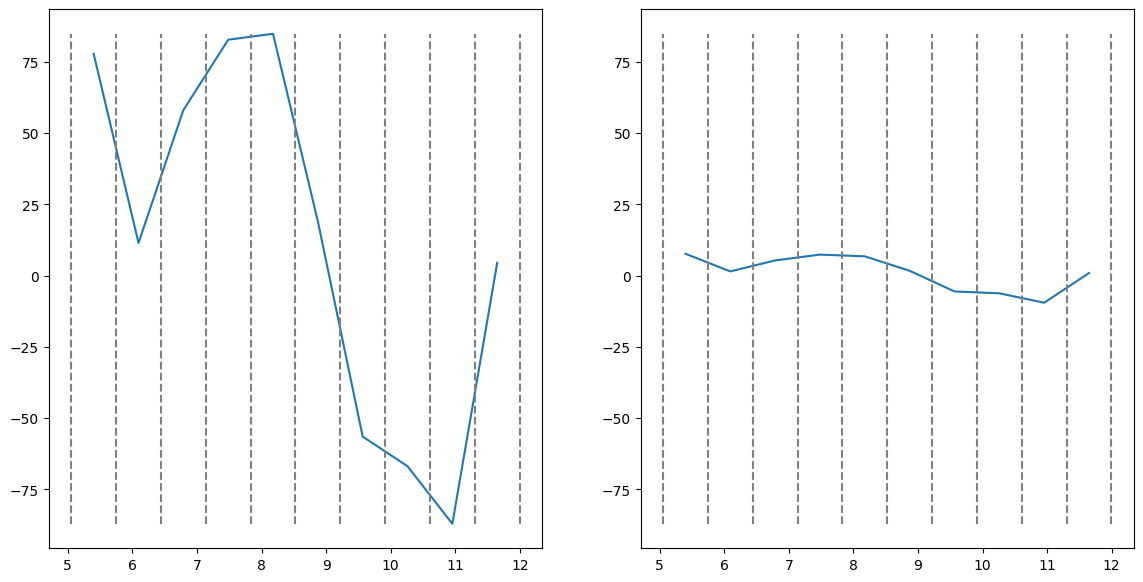

In [106]:
fig, axs = plt.subplots(1,2,figsize = (14, 7))

axs[0].plot(np.array(bin_mids)/1000, np.array(velocity_ellipsoids)[:,0,1])
axs[0].vlines(bin_collection.bin_boundaries[0][0]/1000, 
            np.min(np.array(velocity_ellipsoids)[:,0,1]), 
            np.max(np.array(velocity_ellipsoids)[:,0,1]),
            linestyles='--', color='gray')


vertex_devs = []
for i, bin in enumerate(bin_collection.bins):
    vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
    vertex_devs.append(vertex_dev)

axs[1].plot(np.array(bin_mids)/1000, np.degrees(vertex_devs))
axs[1].vlines(bin_collection.bin_boundaries[0][0]/1000, 
            np.min(np.array(velocity_ellipsoids)[:,0,1]), 
            np.max(np.array(velocity_ellipsoids)[:,0,1]),
            linestyles='--', color='gray')

In [105]:
vertex_devs

[0.13390180582300684,
 0.026091995700790127,
 0.09331340650550679,
 0.12878743114612293,
 0.11843454739574548,
 0.029769084473671246,
 -0.09667028922765719,
 -0.10803034846244286,
 -0.16580179276133566,
 0.016018106018415273]